### **Importing Necessary Modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

### **Load Polar Data**

In [2]:
polar_data = pd.read_csv("../practice-data/polar.csv")
print(polar_data.head())

   timestamp_ms  value
0  5.996162e+11     19
1  5.996162e+11     19
2  5.996162e+11     16
3  5.996162e+11     21
4  5.996162e+11     30


### **Plot _UNFILTERED_ Polar Data**

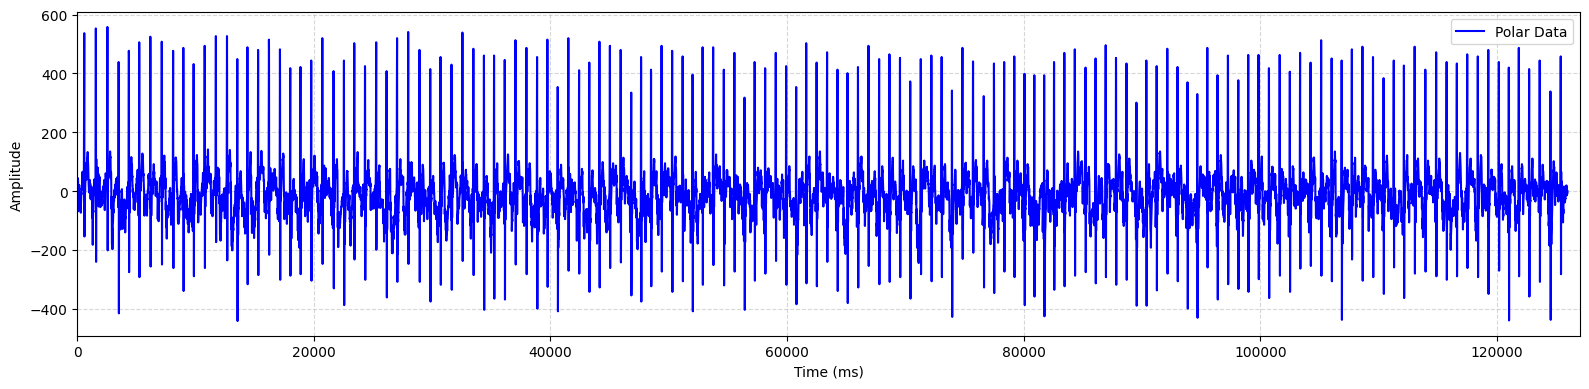

In [98]:
timestamps = polar_data["timestamp_ms"].to_numpy()
ecg_raw = polar_data["value"].to_numpy()

' Normalizing timestamp (ms), such that it starts from 0 ms'
t0 = polar_data["timestamp_ms"].iloc[0]
timestamps = timestamps - t0

plt.figure(figsize=(16, 4))
plt.plot(timestamps, ecg_raw, c='blue', label="Polar Data")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127000)
plt.tight_layout()
plt.show()

### **Estimating PPG Sampling Rate For Filter Design**
- _Higher sampling rate means more data points are captured, allowing for higher resolution of data, and greater analysis of physiological parameters_
- _Sampling frequency simply means how many samples per second_
- _Knowing the sampling frequency, tells us the time resolution of the PPG signal_
- _Suppose a sampling frequency of 25 Hz would mean one reading every 0.04 seconds_
- _How many times per second a signal is snapshot/captured_

### **Formulas**

**Given timestamps \(t_0, t_1, \dots, t_{N-1}\) in milliseconds:**

1. **Inter-sample intervals** (in seconds):

$$
\Delta t_i = \frac{t_{i+1} - t_i}{1000}, \quad
i = 0,1,\dots,N-2
$$

2. **Mean sampling interval**:

$$
\overline{\Delta t} = \frac{1}{N-1} \sum_{i=0}^{N-2} \Delta t_i
$$

3. **Sampling frequency** (Hz):

$$
f_s = \frac{1}{\overline{\Delta t}}
$$

In [99]:
dt = np.diff(timestamps) / 1000.0
fs = 1 / np.mean(dt)
print(f"Estimated PPG sampling rate: {fs:.1f} Hz")

Estimated PPG sampling rate: 129.8 Hz


### **Finding Peaks In _UNFILTERED_ ECG Data**

In [100]:
min_dist = int(0.5 * fs) # the standard formula
peaks, props = find_peaks(ecg_raw, distance=min_dist, height=np.mean(ecg_raw))

### **Plotting Peaks In _UNFILTERED_ ECG Data**

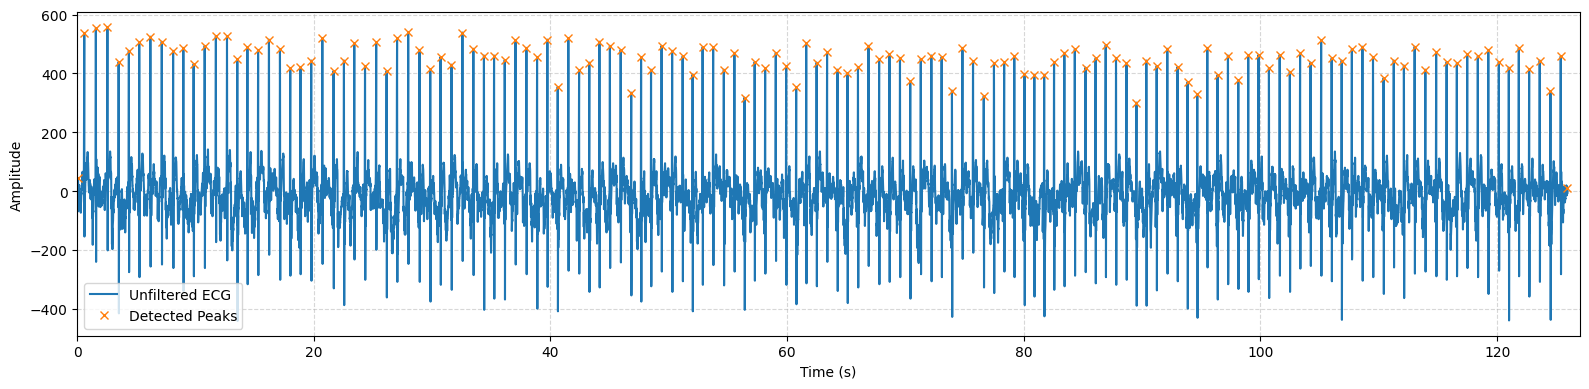

In [101]:
plt.figure(figsize=(16, 4))
t_sec = timestamps / 1000.0
plt.plot(t_sec, ecg_raw, label="Unfiltered ECG")
plt.plot(t_sec[peaks], ecg_raw[peaks], 'x', label="Detected Peaks")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127)
plt.tight_layout()
plt.show()

### **Number Of Peaks Detected in the _UNFILTERED_ ECG Data**

In [102]:
print(f"Detected {len(peaks)} peaks in the Unfiltered ECG")

Detected 144 peaks in the Unfiltered ECG


### **RRIs and IBIs of _UNFILTERED_ ECG Data (milliseconds)**

In [103]:
t_peaks = timestamps[peaks]
rri = np.diff(t_peaks)
print(rri)
print(rri.mean(), np.median(rri), rri.max(), rri.min())

[554.58154297 977.67382812 978.43432617 947.66027832 862.27368164
 878.42431641 939.96264648 962.27380371 963.03979492 862.27368164
 870.73205566 932.27038574 946.88928223 939.96276855 870.7064209
 854.58666992 901.4909668  916.11999512 932.23974609 870.70166016
 862.27380371 909.16296387 939.20202637 947.61938477 878.39367676
 869.96606445 909.13256836 946.88928223 878.36315918 886.06066895
 939.19177246 955.3067627  909.14257812 869.94055176 924.54260254
 923.78161621 924.54772949 893.74780273 854.56628418 901.45544434
 908.3972168  924.54760742 901.44006348 869.93566895 870.70141602
 900.70495605 901.44006348 869.93554688 855.28637695 886.0402832
 908.41235352 886.02514648 839.17138672 839.89660645 893.01245117
 893.74804688 886.02490234 839.16650391 847.56335449 893.04309082
 901.4197998  893.00231934 855.2557373  854.55102539 886.02502441
 901.39953613 877.63305664 847.54309082 846.85351562 878.33276367
 885.32019043 878.30224609 846.85876465 886.02490234 885.3203125
 901.38415527

### **Normal-to-Normal RR Intervals In _UNFILTERED_ ECG**

In [104]:
rri_normal = rri.copy()
mask1 = (rri_normal >= 300) & (rri_normal <= 2000)
rri_normal = rri_normal[mask1]

diffs = np.abs(np.diff(rri_normal))
mask2 = diffs <= 0.2 * rri_normal[:-1]
rri_normal = rri_normal[1:][mask2]
print(rri_normal)

[978.43432617 947.66027832 862.27368164 878.42431641 939.96264648
 962.27380371 963.03979492 862.27368164 870.73205566 932.27038574
 946.88928223 939.96276855 870.7064209  854.58666992 901.4909668
 916.11999512 932.23974609 870.70166016 862.27380371 909.16296387
 939.20202637 947.61938477 878.39367676 869.96606445 909.13256836
 946.88928223 878.36315918 886.06066895 939.19177246 955.3067627
 909.14257812 869.94055176 924.54260254 923.78161621 924.54772949
 893.74780273 854.56628418 901.45544434 908.3972168  924.54760742
 901.44006348 869.93566895 870.70141602 900.70495605 901.44006348
 869.93554688 855.28637695 886.0402832  908.41235352 886.02514648
 839.17138672 839.89660645 893.01245117 893.74804688 886.02490234
 839.16650391 847.56335449 893.04309082 901.4197998  893.00231934
 855.2557373  854.55102539 886.02502441 901.39953613 877.63305664
 847.54309082 846.85351562 878.33276367 885.32019043 878.30224609
 846.85876465 886.02490234 885.3203125  901.38415527 870.63525391
 893.0024414

### **SDNN (standard deviation of normal-to-normal RR-intervals) of _UNFILTERED_ ECG**
- After removing noise and non-sinus beats

In [105]:
sdnn = np.std(rri_normal, ddof=1)
print(sdnn)

31.07332417489063


### **SDRR (standard deviation of all RR-intervals) of _UNFILTERED_ ECG**
- Includes everything, including noise

In [106]:
sdrr = np.std(rri, ddof=1)
print(sdrr)

52.811760909522214


### **The RMSSD (Root Mean Square of Successive Differences) of _UNFILTERED_ ECG**

$$
\mathrm{RMSSD} = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N-1} \bigl(RR_{i+1} - RR_i\bigr)^2}
$$

- **\(RR_i\): the \(i\)-th successive R–R interval (in milliseconds)**
- **\(N\): total number of R–R intervals**

In [107]:
diff_rri = np.diff(rri)
rmmsd = np.sqrt(np.mean(diff_rri ** 2))
print(rmmsd)

56.45178283097001


### **The pNN50 (percentage of successive RR-interval differences greater than 50 ms) of _UNFILTERED_ ECG**

$$
\mathrm{pNN50} = \frac{\displaystyle\sum_{i=1}^{N-1} \mathbb{I}\bigl(\lvert RR_{i+1} - RR_{i}\rvert > 50\text{ ms}\bigr)}{N - 1} \times 100\%
$$

- **\(RR_i\): the \(i\)-th successive R–R interval (in milliseconds)**
- **\(N\): total number of R–R intervals**
- **1 if condition is True, 0 otherwise**

In [108]:
pnn50 = (np.sum(np.abs(diff_rri) > 50) / len(diff_rri)) * 100
print(pnn50)

11.971830985915492


### **HR Max, HR Min and HR Range From _UNFILTERED_ ECG**

In [109]:
hr = 60000 / rri
hr_range = np.max(hr) - np.min(hr)
print(hr.max())
print(hr.min())
print(hr_range)

119.83838202580309
61.3224601744606
58.51592185134248


### **Creating a Band-pass Filter for Filtering ECG Data**
- _Blocking out frequencies below 0.5 Hz, as that falls under baseline drift (the value a signal exhibits, when no significant change or event is present, essentially the "resting state" of a signal)_
- _Blocking out frequencies above 8 Hz, as those fall under the category of non-cardiac signals or **HIGH FREQUENCY NOISE**_
- _Designing a 3rd order butterworth bandpass filter for pass-band of [0.5, 8]_

In [124]:
from scipy.signal import butter

lowcut, highcut = 0.5, 8.0
nyq = 0.5 * fs
b, a = butter(3, [lowcut/nyq, highcut/nyq], btype='band')  # Getting numerator b, and denominator a polynomials for the 3rd order IIR filter

### **Filtering the ECG Data**

In [ ]:
from scipy.signal import filtfilt

'filtfilt() applies zero-phase filtering, allowing us to keep the peaks aligned with the raw signal'
ecg_filt = filtfilt(b, a, ecg_raw)  # filtering the raw PPG according to the coefficients from the Butterworth band-pass filter

### **Plotting Filtered ECG Data**

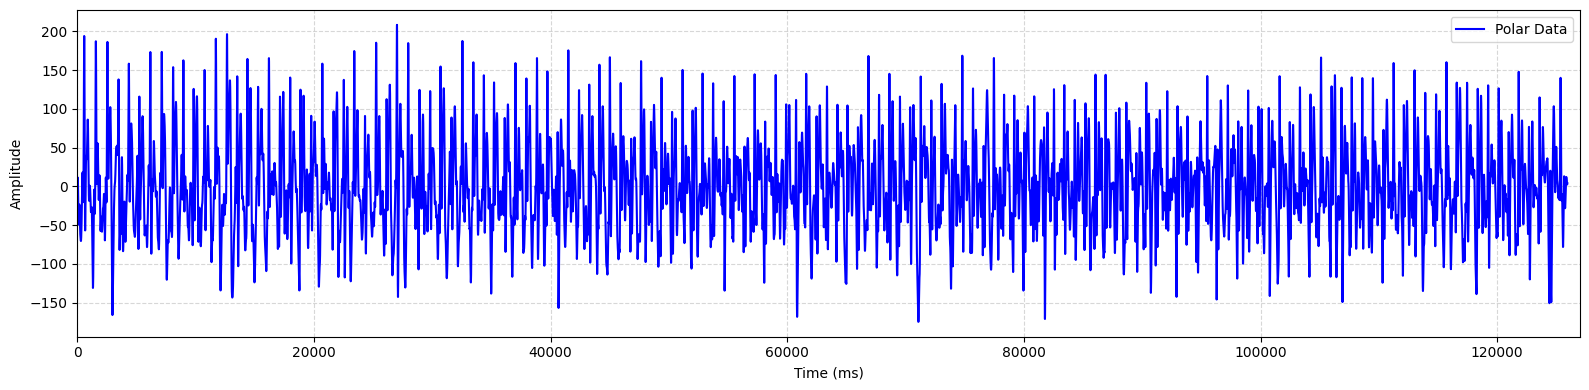

In [112]:
plt.figure(figsize=(16, 4))
plt.plot(timestamps, ecg_filt, c='blue', label="Polar Data")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127000)
plt.tight_layout()
plt.show()

### **Finding Peaks In Filtered ECG Data**

In [125]:
from scipy.signal import find_peaks

min_dist = int(0.5 * fs)
peaks, props = find_peaks(ecg_filt, distance=min_dist, height=np.mean(ecg_filt))

### **Plotting Peaks In Filtered ECG Data**

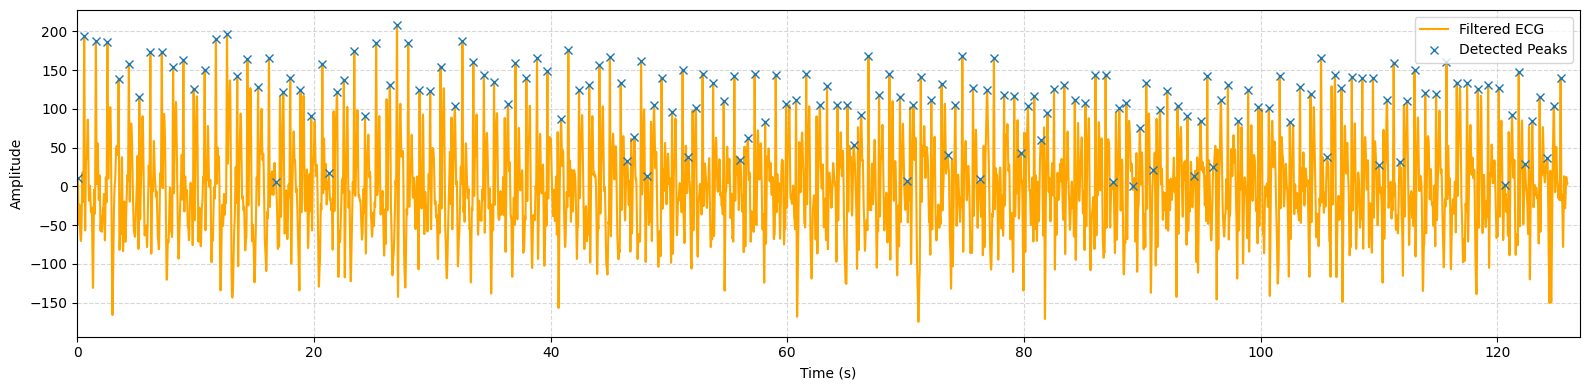

In [126]:
plt.figure(figsize=(16, 4))
t_sec = timestamps / 1000.0
plt.plot(t_sec, ecg_filt, c="orange", label="Filtered ECG")
plt.plot(t_sec[peaks], ecg_filt[peaks], 'x', label="Detected Peaks")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127)
plt.tight_layout()
plt.show()

### **Number Of Peaks Detected in the Filtered ECG Data**

In [115]:
print(f"Detected {len(peaks)} peaks in the Filtered ECG")

Detected 166 peaks in the Filtered ECG


### **RRIs and IBIs in Filtered ECG (milliseconds)**

In [116]:
t_peaks = timestamps[peaks]
rri = np.diff(t_peaks)
print(rri)
print(rri.mean(), np.median(rri), rri.max(), rri.min())

[ 546.88916016  985.36608887  978.43444824  939.96789551  869.96594238
  886.11669922  931.50463867  963.03955078  963.03979492  862.27368164
  870.73205566  924.57800293  954.58154297  939.96276855  863.01416016
  862.27893066  901.49108887  916.11999512  593.04284668  616.11999512
  586.08618164  869.96606445  909.16308594  939.2019043   554.58666992
  686.07580566  569.96606445  885.35070801  909.13256836  946.88916016
 1147.59399414  609.13769531  946.8840332   955.30664062  901.45031738
  877.63293457 1201.46569824  646.85852051  924.54772949  886.05541992
  862.25866699 1170.68615723  639.16638184  924.54760742  893.7479248
  877.62780762 1155.31689453  616.08959961  901.44006348  869.93554688
  855.28625488  886.04040527  908.41235352  523.78173828  646.85876465
  554.55603027  531.49938965  562.24328613  639.16638184  893.74804688
  885.32006836  493.01245117  616.08959961  577.62780762  893.74780273
  893.72766113  900.69458008  493.01257324  639.16625977  577.62792969
  893.7

### **Normal-to-Normal RR Intervals In Filtered ECG**

In [117]:
rri_normal = rri.copy()
mask1 = (rri_normal >= 300) & (rri_normal <= 2000)
rri_normal = rri_normal[mask1]

diffs = np.abs(np.diff(rri_normal))
mask2 = diffs <= 0.2 * rri_normal[:-1]
rri_normal = rri_normal[1:][mask2]
print(rri_normal)

[978.43444824 939.96789551 869.96594238 886.11669922 931.50463867
 963.03955078 963.03979492 862.27368164 870.73205566 924.57800293
 954.58154297 939.96276855 863.01416016 862.27893066 901.49108887
 916.11999512 616.11999512 586.08618164 909.16308594 939.2019043
 569.96606445 909.13256836 946.88916016 955.30664062 901.45031738
 877.63293457 886.05541992 862.25866699 893.7479248  877.62780762
 869.93554688 855.28625488 886.04040527 908.41235352 554.55603027
 531.49938965 562.24328613 639.16638184 885.32006836 577.62780762
 893.72766113 900.69458008 577.62792969 893.01257324 878.32763672
 839.85083008 854.54589844 846.85888672 623.78173828 616.08959961
 870.63525391 893.00231934 562.2434082  616.08935547 869.90515137
 593.68701172 592.98181152 577.62805176 854.55078125 616.08947754
 539.16638184 585.28967285 531.47412109 554.55090332 885.3203125
 901.35876465 847.52270508 862.23828125 516.05895996 593.01245117
 585.28967285 554.52050781 546.85864258 593.01269531 554.52026367
 623.7512207

### **SDNN (standard deviation of normal-to-normal RR-intervals) of Filtered ECG**
- After removing noise and non-sinus beats

In [118]:
sdnn = np.std(rri_normal, ddof=1)
print(sdnn)

158.17360579769834


### **SDRR (standard deviation of all RR-intervals) of Filtered ECG**
- Includes everything, including noise

In [119]:
sdrr = np.std(rri, ddof=1)
print(sdrr)

173.83637742743977


### **The RMSSD (Root Mean Square of Successive Differences) of Filtered ECG**

$$
\mathrm{RMSSD} = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N-1} \bigl(RR_{i+1} - RR_i\bigr)^2}
$$

- **\(RR_i\): the \(i\)-th successive R–R interval (in milliseconds)**
- **\(N\): total number of R–R intervals**

In [120]:
diff_rri = np.diff(rri)
rmmsd = np.sqrt(np.mean(diff_rri ** 2))
print(rmmsd)

190.2178641428469


### **The pNN50 (percentage of successive RR-interval differences greater than 50 ms) of Filtered ECG**

$$
\mathrm{pNN50} = \frac{\displaystyle\sum_{i=1}^{N-1} \mathbb{I}\bigl(\lvert RR_{i+1} - RR_{i}\rvert > 50\text{ ms}\bigr)}{N - 1} \times 100\%
$$

- **\(RR_i\): the \(i\)-th successive R–R interval (in milliseconds)**
- **\(N\): total number of R–R intervals**
- **1 if condition is True, 0 otherwise**

In [121]:
pnn50 = (np.sum(np.abs(diff_rri) > 50) / len(diff_rri)) * 100
print(pnn50)

49.390243902439025


### **HR Max, HR Min and HR Range From Filtered ECG**

In [122]:
hr = 60000 / rri
hr_range = np.max(hr) - np.min(hr)
print(hr.max())
print(hr.min())
print(hr_range)

121.7083140605392
49.939003741666035
71.76931031887315
